In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [ ]:
import ast
import csv
import itertools
from itertools import product
import numpy as np
import pandas as pd

from loss_functions import *
from src.activation_functions import *
from src.batch_normalization import *
from src.data_preprocessing import *
from src.cascade_correlation import CascadeCorrelation
from src.k_fold_cross_validation import *
from src.layer import *
from src.early_stopping import EarlyStopping
from src.neural_network import *
from src.optimizers import *
from src.random_search import *
from src.train_and_evaluate import Train
from src.utils import *

# from src.random_search import *

np.random.seed(0)

<!-- #### Data pre-processing for MONK Datasets  -->

In [4]:
MONK_NUM=2
X_train, y_train = load_data(MONK_NUM=MONK_NUM)
X_test, y_test = load_data(MONK_NUM=MONK_NUM, train=False)

one hot encoded data:  (169, 17)
one hot encoded data:  (432, 17)


In [5]:
X_train, X_val = train_test_split(X_train)
y_train, y_val = train_test_split(y_train)
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

In [6]:
print("Training set size:", len(X_train))
print("Validation set size:", len(X_val))

Training set size: 135
Validation set size: 34


In [7]:
# Print the shape of the resulting datasets
for _ in [X_train, X_val, y_train, y_val]:
    print(f"the shape: ", _.shape)

the shape:  (135, 17)
the shape:  (34, 17)
the shape:  (135, 1)
the shape:  (34, 1)


In [37]:
param_distributions = {
    'learning_rate': [0.0379269019073225],
    'l1': [1e-5],
    'l2': [0.00021544346900318823],
    'dropout_rate': [2.782559402207126e-05],
    'batch_size': [16],
    'n_epochs': [100],
    'hidden_size': [5],
    'hidden_activation': [Activation_Leaky_ReLU],
    'batch_norm': [False],
    'weight_decay': [1e-5],
    'patience': [50],
    'n_h_layers': [2],
    'weights_init': ['he'],
    'output_activation': [Activation_Sigmoid()],
    'sched_decay': [1]
}

print(f"Number of possible combinations: {count_permutations(param_distributions)}")

Number of possible combinations: 1


In [38]:
best_hyperparams, best_performance = random_search(X_train=X_train, y_train=y_train, param_distributions=param_distributions, n_iters=1, csv_path=f"monk{MONK_NUM}_top5res.csv")  # adjust n_iters as needed

print(best_hyperparams)

Iteration 0
✅ Fold 1/5 | Validation Accuracy: 1.0000
✅ Fold 2/5 | Validation Accuracy: 1.0000
✅ Fold 3/5 | Validation Accuracy: 1.0000
✅ Fold 4/5 | Validation Accuracy: 1.0000
✅ Fold 5/5 | Validation Accuracy: 1.0000
📊 Manual K-Fold | Mean Validation Accuracy over 5 folds: 1.0000

{'learning_rate': 0.0379269019073225, 'l1': 1e-05, 'l2': 0.00021544346900318823, 'dropout_rate': 2.782559402207126e-05, 'batch_size': 16, 'n_epochs': 100, 'hidden_size': 5, 'hidden_activation': <class 'src.activation_functions.Activation_Leaky_ReLU'>, 'batch_norm': False, 'weight_decay': 1e-05, 'patience': 50, 'n_h_layers': 2, 'weights_init': 'he', 'output_activation': <src.activation_functions.Activation_Sigmoid object at 0x7f5032b87b00>, 'sched_decay': 1, 'CC': False, 'val_accuracy': np.float64(1.0)}


In [39]:
print(best_hyperparams)

{'learning_rate': 0.0379269019073225, 'l1': 1e-05, 'l2': 0.00021544346900318823, 'dropout_rate': 2.782559402207126e-05, 'batch_size': 16, 'n_epochs': 100, 'hidden_size': 5, 'hidden_activation': <class 'src.activation_functions.Activation_Leaky_ReLU'>, 'batch_norm': False, 'weight_decay': 1e-05, 'patience': 50, 'n_h_layers': 2, 'weights_init': 'he', 'output_activation': <src.activation_functions.Activation_Sigmoid object at 0x7f5032b87b00>, 'sched_decay': 1, 'CC': False, 'val_accuracy': np.float64(1.0)}


GRID SEARCH

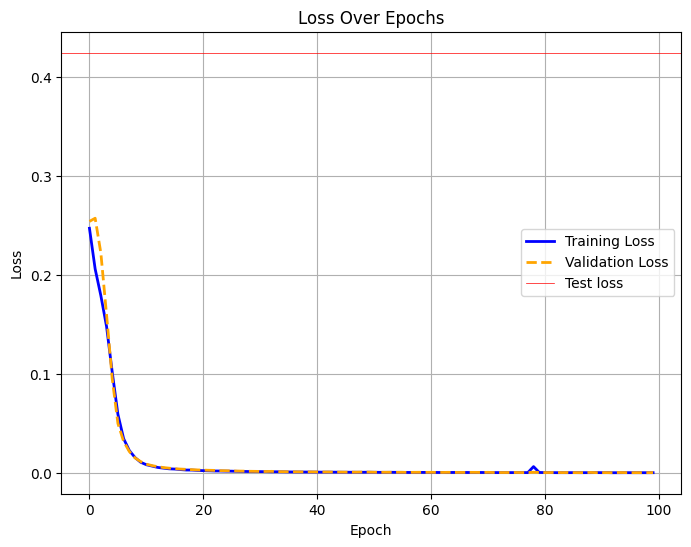

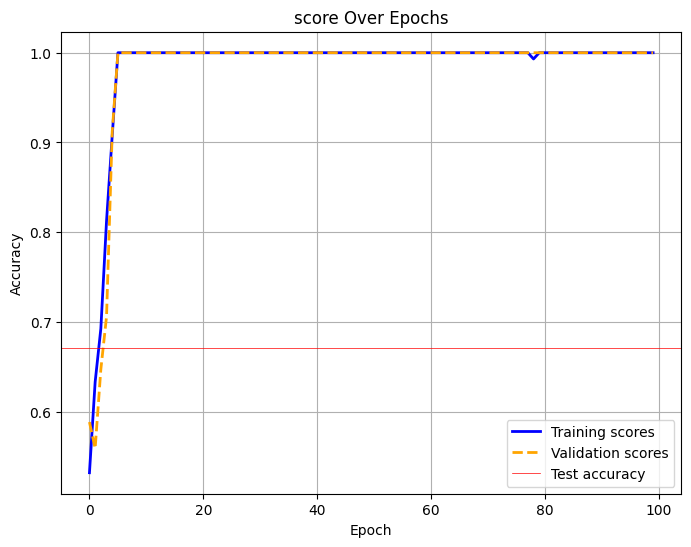

In [40]:
if best_hyperparams['CC']:
    model = CascadeCorrelation(input_size = 17, output_size= 1, activation=Activation_Leaky_ReLU, output_activation = Activation_Sigmoid)
else:
    model = NN(
        l1=best_hyperparams['l1'],
        l2=best_hyperparams['l2'],
        input_size=17,
        hidden_size=best_hyperparams['hidden_size'],
        output_size=1,
        hidden_activation=best_hyperparams['hidden_activation'],
        dropout_rate=best_hyperparams['dropout_rate'],
        use_batch_norm=best_hyperparams['batch_norm'],
        n_h_layers=best_hyperparams['n_h_layers'],
        output_activation=best_hyperparams['output_activation'],
        weights_init=best_hyperparams['weights_init']
    )

train = Train(best_hyperparams, model)
train.train_and_evaluate(X_train, y_train, X_val, y_val)
train.test(X_test, y_test)
train.plot(score=True)

In [41]:
print(train.train_losses, train.val_losses)

[np.float64(0.24720846457703383), np.float64(0.20612893725000997), np.float64(0.17921165830131452), np.float64(0.14809256355816328), np.float64(0.1019590342778614), np.float64(0.059270440151216706), np.float64(0.03481659493229413), np.float64(0.02282016944233097), np.float64(0.015709911889961403), np.float64(0.010897405654843532), np.float64(0.008410258262429225), np.float64(0.007059694203126533), np.float64(0.005693318323364188), np.float64(0.004967290946908215), np.float64(0.0042904292983277125), np.float64(0.004051957011380264), np.float64(0.003511515644439784), np.float64(0.003081467536520001), np.float64(0.0030524855373990716), np.float64(0.002687742971596808), np.float64(0.0024437595734659095), np.float64(0.0022969281696324775), np.float64(0.002112700554135949), np.float64(0.002092859679638474), np.float64(0.001973493125902282), np.float64(0.0019261998755782368), np.float64(0.001751022931601811), np.float64(0.0016368837369372215), np.float64(0.0015674377768919666), np.float64(0.0

In [42]:
print(f"Test Accuracy: {train.test_score:.4f}")

Test Accuracy: 0.6713


In [43]:
class EnsembleNN:
    def __init__(self, n_models=5):
        self.models = []
        self.n_models = n_models
        self.loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
        

    def create_and_train_models(self, hyperparams):
        # Create and train multiple models with the same hyperparameters
        for i in range(self.n_models):
            model = NN(
                l1=hyperparams['l1'],
                l2=hyperparams['l2'],
                input_size=17,
                hidden_size=hyperparams['hidden_size'],
                output_size=1,
                hidden_activation=hyperparams['hidden_activation'],
                dropout_rate=hyperparams['dropout_rate'],
                use_batch_norm=hyperparams['batch_norm'],
                n_h_layers=hyperparams['n_h_layers']
            )
            print(f"Training model {i+1}/{self.n_models}")
            # Train model using existing train_and_evaluate function
            self.train = Train(hyperparams, model)
            model, val_accuracy = self.train.train_and_evaluate(
                X_train=X_train,
                y_train=y_train,
                X_val=X_val,
                y_val=y_val,
            )
            self.models.append(model)
            print(f"Model {i+1} validation accuracy: {val_accuracy:.4f}")

    def predict(self, X):
        """Make predictions using majority voting"""
        predictions = []
        for model in self.models:
            model.forward(X, training=False)
            self.loss_activation.forward(
                model.output, np.zeros((X.shape[0], 2)))  # Dummy y values
            pred = np.argmax(self.loss_activation.output, axis=1)
            predictions.append(pred)

        # Majority voting
        predictions = np.array(predictions)
        final_predictions = np.apply_along_axis(
            lambda x: np.bincount(x).argmax(),
            axis=0,
            arr=predictions
        )
        return final_predictions

Training model 1/5
Model 1 validation accuracy: 0.5294
Training model 2/5
Model 2 validation accuracy: 1.0000
Training model 3/5
Model 3 validation accuracy: 1.0000
Training model 4/5
Model 4 validation accuracy: 1.0000
Training model 5/5
Model 5 validation accuracy: 1.0000
Ensemble Test Accuracy: 0.6713


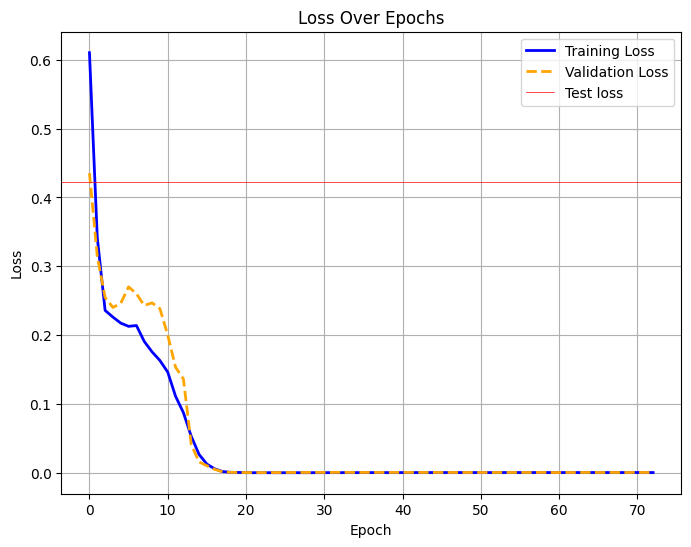

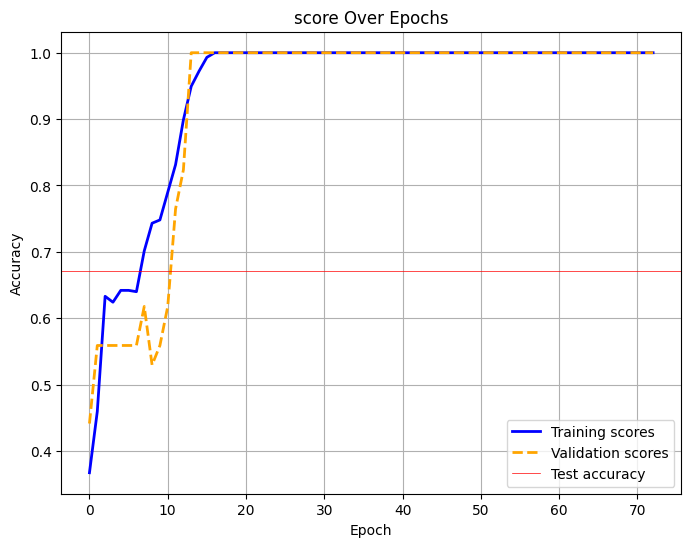

In [44]:
ensemble = EnsembleNN(n_models=5)

ensemble.create_and_train_models(best_hyperparams)

_ , test_accuracy = ensemble.train.test(X_test, y_test)

print(f"Ensemble Test Accuracy: {test_accuracy:.4f}")

ensemble.train.plot(score=True)